# Transfer Learning

In [21]:
!nvidia-smi
!pwd
isLocalServer = True

Mon Aug 29 14:52:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:04:00.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |    729MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:06:00.0 Off |                    0 |
| N/A   

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import json, os, sys
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

cudnn.benchmark = True
plt.ion()

if isLocalServer is True:
  path_to_be_add = '/notebook/personal/ksuchoi216/face-id-model/'
  if not path_to_be_add in sys.path:
    sys.path.insert(0, path_to_be_add)
    os.chdir(path_to_be_add)

  print(f'sys.path: {sys.path}')

def load_config():
  path_for_config = './configs/config.json'
  with open(path_for_config) as f:
    cfg = json.load(f)
  
  return cfg
cfg = load_config()


sys.path: ['/notebook/personal/ksuchoi216/face-id-model/', '/notebook', '/root/.pyenv/versions/3.9.1/lib/python39.zip', '/root/.pyenv/versions/3.9.1/lib/python3.9', '/root/.pyenv/versions/3.9.1/lib/python3.9/lib-dynload', '', '/root/.pyenv/versions/python39/lib/python3.9/site-packages']


250
 data 
0 jhoh
1 jhongyoo
2 jhyoo
3 kschoi
batch_size: 4 

dataset length: (608) = tr (486) + val (60) + tt (62)
image dimension: (3, 250, 250)


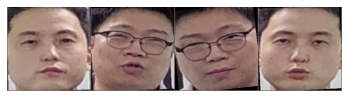

input shape: torch.Size([3, 250, 250]) / label shape: torch.Size([]) / label: 2
input shape: torch.Size([3, 250, 250]) / label shape: torch.Size([]) / label: 2
input shape: torch.Size([3, 250, 250]) / label shape: torch.Size([]) / label: 3
input shape: torch.Size([3, 250, 250]) / label shape: torch.Size([]) / label: 0


In [23]:
from datasets import Folder_Dataset
from utils import imshow_dataloader
folder_Dataset = Folder_Dataset(cfg['data'])
dataloaders, dataset_sizes, idx_to_class = folder_Dataset.createDataLoaders()

# show a example picture 
image_size = imshow_dataloader(dataloaders["train"])

phase="train"
for i, (inputs, labels) in enumerate(dataloaders[phase]):
  if i > 3:
    break
  
  print(f'input shape: {inputs[0].shape} / label shape: {labels[0].shape} / label: {labels[0]}')
  

In [24]:
from modules import Builder

builder = Builder(cfg['model'])
print(image_size)
builder.summary(image_size)
model = builder.getModel()

device is cuda:0
Loading model was just completed.
(3, 250, 250)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 124, 124]             864
       BatchNorm2d-2         [-1, 32, 124, 124]              64
              ReLU-3         [-1, 32, 124, 124]               0
       BasicConv2d-4         [-1, 32, 124, 124]               0
            Conv2d-5         [-1, 32, 122, 122]           9,216
       BatchNorm2d-6         [-1, 32, 122, 122]              64
              ReLU-7         [-1, 32, 122, 122]               0
       BasicConv2d-8         [-1, 32, 122, 122]               0
            Conv2d-9         [-1, 64, 122, 122]          18,432
      BatchNorm2d-10         [-1, 64, 122, 122]             128
             ReLU-11         [-1, 64, 122, 122]               0
      BasicConv2d-12         [-1, 64, 122, 122]               0
        MaxPool2d-13           [-1, 64

In [25]:
# declaration for learning and testing|
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [39]:
from modules import runner
phases = ['train', 'val']
# print(runner)
model, train_evaluation_matrix, val_evaluation_matrix = runner(model, phases, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=10)

--------------------------------------------------
Epoch 0/9
train Loss: 0.2058 Acc: 0.9342 recall: 0.9367 Precision: 0.9344
val Loss: 0.0583 Acc: 0.9667 recall: 0.9410 Precision: 0.9380
--------------------------------------------------
--------------------------------------------------
Epoch 1/9
train Loss: 0.2740 Acc: 0.9115 recall: 0.9156 Precision: 0.9103
val Loss: 0.1147 Acc: 0.9500 recall: 0.9200 Precision: 0.9161
--------------------------------------------------
--------------------------------------------------
Epoch 2/9
train Loss: 0.2342 Acc: 0.9115 recall: 0.9133 Precision: 0.9115
val Loss: 0.1441 Acc: 0.9667 recall: 0.9198 Precision: 0.9186
--------------------------------------------------
--------------------------------------------------
Epoch 3/9
train Loss: 0.1952 Acc: 0.9321 recall: 0.9382 Precision: 0.9298
val Loss: 0.0340 Acc: 0.9833 recall: 0.9438 Precision: 0.9359
--------------------------------------------------
------------------------------------------------

In [40]:
train_evaluation_numpy = train_evaluation_matrix.to('cpu').numpy()
val_evaluation_numpy = val_evaluation_matrix.to('cpu').numpy()

10 4


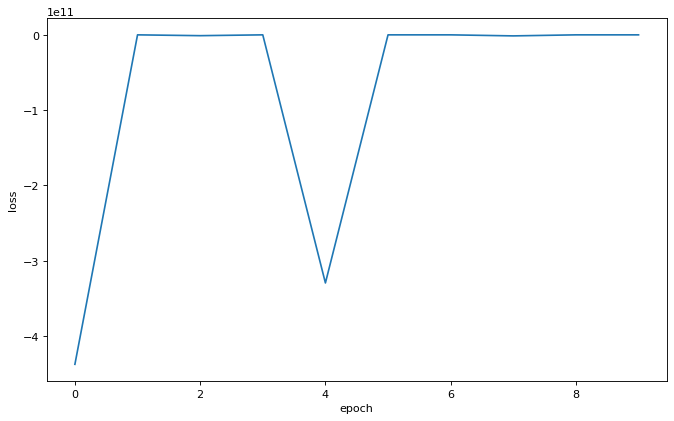

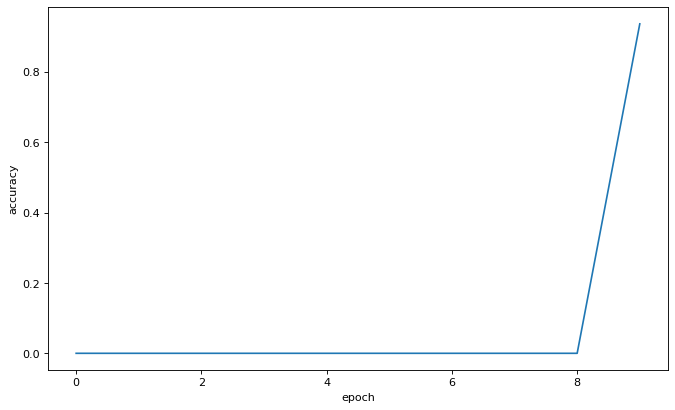

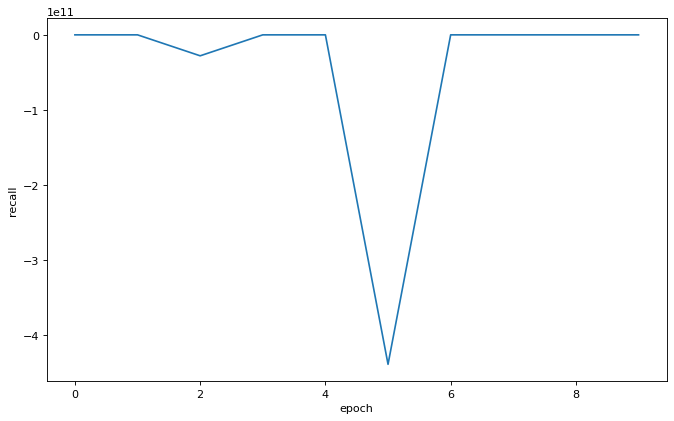

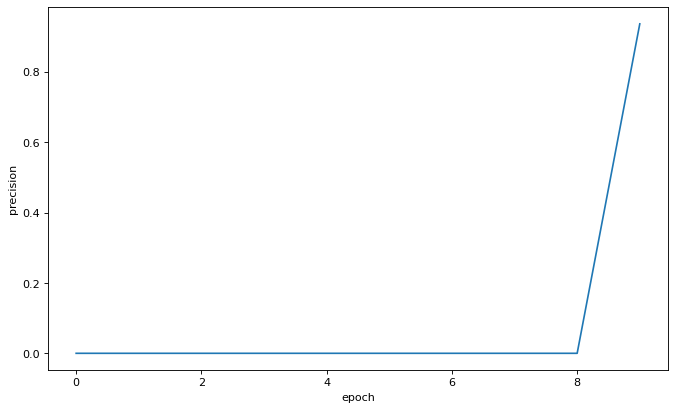

In [71]:
num_epochs, num_evaluations = train_evaluation_numpy.shape
print(num_epochs, num_evaluations)


title_list = ['loss', 'accuracy', 'recall', 'precision']
for col, title in zip(range(0, num_evaluations), title_list):
  plt.figure(figsize=(10, 6), dpi=80)
  plt.ylabel(title)
  plt.xlabel('epoch')
  plt.plot(range(0, num_epochs), train_evaluation_numpy[:, col])
  plt.show()

In [9]:
phases = ['test']
runner(model, phases, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=1)

Epoch 0/0
----------
test Loss: 0.1059 Acc: 0.9677

Training complete in 0m 1s
Best val Acc: 0.000000
there is no return value becasue of test mode


## Save trained model

In [10]:
cfg = load_config()
path_for_saving_model = cfg['path_for_saving_model']
try: 
  torch.save(model.state_dict(), path_for_saving_model)
  print(f'successfully saved model in {path_for_saving_model}')
except:
  print(f'failed saving model in {path_for_saving_model}')

successfully saved model in ./data/face-extraction-model.pt


# [TEST] face_feature_extractor with trained classifier(last layer)

In [14]:
phases = ['test']
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for phase in phases:
  for i, (inputs, labels) in enumerate(dataloaders[phase]):
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    print('outputs before softmax:', outputs)
    outputs = F.softmax(outputs)
    print('outputs after softmax:', outputs)
    values, preds = torch.max(outputs, 1)
    print(values)
    
    
    print('\n')
    if i > 2:
      break
    

outputs before softmax: tensor([[ 8.0832, -2.8448, -0.9191, -2.7058],
        [-2.2343,  6.6496, -3.4869, -0.1292],
        [ 8.1746,  0.0634, -0.0749, -7.4552],
        [-1.7504, -2.5398, -2.4510,  5.6972]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
outputs after softmax: tensor([[9.9984e-01, 1.7947e-05, 1.2311e-04, 2.0622e-05],
        [1.3842e-04, 9.9869e-01, 3.9557e-05, 1.1361e-03],
        [9.9944e-01, 3.0000e-04, 2.6125e-04, 1.6285e-07],
        [5.8220e-04, 2.6439e-04, 2.8894e-04, 9.9886e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
tensor([0.9998, 0.9987, 0.9994, 0.9989], device='cuda:0',
       grad_fn=<MaxBackward0>)


outputs before softmax: tensor([[ 0.0463, -1.7936,  7.1511, -1.7509],
        [-0.5652, -1.1555,  8.3769, -4.5262],
        [-0.0802, -3.1068,  4.0859, -0.6531],
        [-3.0848,  0.3338, -2.4058,  4.5731]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
outputs after softmax: tensor([[8.2027e-04, 1.3029e-04, 9.9891e-01, 1.3597e-04],
  

In [12]:
import torch
preds = torch.Tensor([1,1,1,1,0,1,0,0,0,1]).int().sum()
print('preds: ',preds)
true = torch.Tensor([0,1,1,1,0,1,0,0,1,1]).int().sum()
print('true: ',true)


preds:  tensor(6)
true:  tensor(6)


In [19]:
import torch

preds_list = [1,1,1,0,0,0,1,1]
labels_list = [1,1,1,0,0,1,1,1]


def macro_evaluation(preds_list, labels_list):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  torch_preds = torch.Tensor(preds_list).int().to(device)
  torch_labels = torch.Tensor(labels_list).int().to(device)

  num_classes = len(torch.unique(torch_labels))
  precision = 0
  recall = 0
  
  for class_ in torch.unique(torch_labels):
    temp_true = torch.where(torch_labels == class_, 1, 0)
    temp_pred = torch.where(torch_preds == class_, 1, 0)
    
    tp = torch.where((temp_true == 1) & (temp_pred == 1), 1, 0).sum()
    fp = torch.where((temp_true == 0) & (temp_pred == 1), 1, 0).sum()
    fn = torch.where((temp_true == 1) & (temp_pred == 0), 1, 0).sum()
    
    temp_recall = tp / (tp + fn + 1e-6)
    temp_precision = tp / (tp + fp + 1e-6)
    
    precision += temp_precision
    recall += temp_recall
  
  precision /= num_classes
  recall /= num_classes
  
  return recall, precision

recall, precision = macro_precision(preds_list, labels_list)
print(recall, precision)
    

tensor(0.9167, device='cuda:0') tensor(0.8333, device='cuda:0')
